# Les projets Open Source de Machine Learning sont-ils menés par des chercheurs ?

## Préambule

Nous observons l'apparition fréquente de nouveaux algorithmes de Machine Learning et leur intégration à des bibliothèques Open Source.

Nous pensons que de nombreux contributeurs hétéroclites participent à ces projets notamment une minorité de chercheurs qui effectuent des travaux dans le domaine de l'apprentissage automatique, mais que ce sont ces chercheurs qui contribuent majoritairement à l'avancée de ces projets.

Nous souhaitons évaluer les hypothèses suivantes :
* Les contributeurs sont majoritairement des chercheurs.
* Les contributions viennent majoritairement de chercheurs.
* Un chercheur qui contribue s'investit sur le long terme.

Nos hypothèses de travail définissent certaines notions et concernent la bonne foi des contributeurs dans les informations de *commit* :
* Un chercheur possède une adresse mail d'une académie *ou* possède un profil d'auteur de publications sur Google Scholar.
* Le nom/prénom spécifié dans chaque *commit* est celui de l'auteur.
* L'adresse mail spécifiée dans chaque *commit* est celui de l'auteur.

Pour avoir un horizon le plus large possible, nous allons mener l'étude sur quatorze projet open source de Machine Learning (voir la liste à la racine de notre [dépôt Git](https://github.com/AntoineAube/reace-study)).

Les données que nous exploitons dans ce document sont issues de l'exécution de plusieurs scripts :
* Extraction d'informations depuis le dépôt Git des projets avec Repodriller.
* Classification des critères pour déterminer quels utilisateurs sont des chercheurs.
Le nécessaire pour reproduire l'étude est disponible sur notre dépôt Git.

In [1]:
# Let us import some awesome libraries!
import pandas as pd
import numpy as np
import math
import os
from operator import itemgetter
import datetime

import pygal

# Definition of some constants.
DATASETS_LOCATION = 'drilled-informations/commits-information'

In [2]:
# Let us load the commits datasets.

projects_commits = {}

for filename in map(lambda filename: filename.split('.csv')[0], os.listdir(DATASETS_LOCATION)):
    commits = pd.read_csv(DATASETS_LOCATION + '/' + filename + '.csv')
    
    # Add a PROJECT column because they are going to be merged.
    commits['PROJECT'] = filename
    
    # The generated timestamps are 1000 times to big for unknown reason.
    commits['TIMESTAMP'] = commits['TIMESTAMP'].apply(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000))
    
    projects_commits[filename] = commits
    
projects_commits['scikit-learn'].sample(3)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT
5813,b5d63bafe243100135da94d89fd8824bd1096da7,Brian Holt,bdholt1@gmail.com,1,2011-09-03 11:35:07,8,12,0,scikit-learn
19044,d16e9eeb1b7bac18dcfd99ed3c8470c7d05eb3f3,Olivier Grisel,olivier.grisel@ensta.org,3,2015-02-06 18:13:10,108,15,0,scikit-learn
4867,1e56a3ca6fe65ac7186c78e0e94d3ba013aae66c,vene,vlad@vene.ro,2,2011-07-16 17:30:54,21,27,0,scikit-learn


## Quels sont les contributeurs chercheurs ?

Conformément à notre hypothèse de travail, nous avons retenu deux critères pour déterminer quel contributeur est un chercheur.

Un script ultérieurement exécuté a constitué un set de données de la manière suivante :
* À partir de la liste des *commits* de chaque projet, lister les contributeurs par leur nom ; pour chaque contributeur, lister ses adresses mail.
* À partir d'une liste blanche de domaines d'adresses mail académiques, déterminer pour chaque contributeur s'il a au moins une adresse académique.
* À partir du nom de chaque contributeur, faire une recherche d'auteur de publications sur Google Scholar pour déterminer s'il en est connu ou non.

In [3]:
contributors_status = pd.read_csv('known-contributors.csv')

contributors_status.sample(3)

,NAME,HAS_RESEARCHER_EMAIL,HAS_PUBLICATION
841,Ben Poole,False,True
3590,maheshakya,False,False
1969,"Flynn, Michael D",False,False


En conservant l'union des deux colonnes calculées, nous pouvons déterminer quels contributeurs nous considérons être des chercheurs.

In [4]:
def decide_if_researcher(row):
    if math.isnan(row['HAS_RESEARCHER_EMAIL']):
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION']
    elif math.isnan(row['HAS_PUBLICATION']):
        row['IS_RESEARCHER'] = row['HAS_RESEARCHER_EMAIL']
    else:
        row['IS_RESEARCHER'] = row['HAS_PUBLICATION'] or row['HAS_RESEARCHER_EMAIL']
        
    return row

contributors_status = contributors_status.apply(decide_if_researcher, axis = 1)

contributors_status.set_index('NAME', inplace = True)

contributors_status.sample(3)

,HAS_RESEARCHER_EMAIL,HAS_PUBLICATION,IS_RESEARCHER
NAME,,,
Tendrid,False,False,False
Emad El-Haraty,False,False,False
Yann Malet,False,False,False


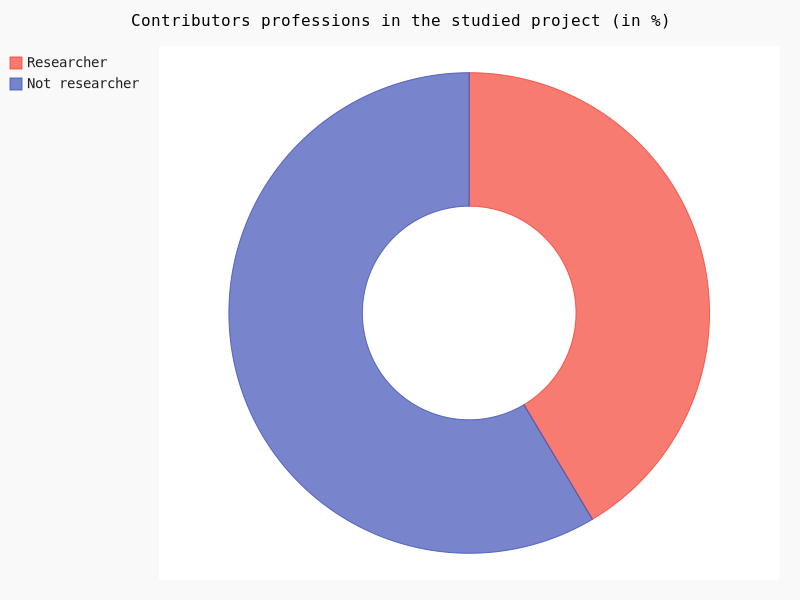

In [5]:
researchers_distribution = contributors_status['IS_RESEARCHER'].value_counts() / len(contributors_status)

pie = pygal.Pie(inner_radius = .4)
pie.title = 'Contributors professions in the studied project (in %)'
pie.add('Researcher', researchers_distribution[True])
pie.add('Not researcher', researchers_distribution[False])

In [6]:
# Let us annotate the commits for future uses.
def commit_has_been_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['AUTHOR_NAME']]
    
    return row

for project_name in projects_commits.keys():
    commits = projects_commits[project_name]
    
    projects_commits[project_name] = commits.apply(commit_has_been_made_by_researcher, axis = 1)

## Questions de l'étude

Les hypothèses de l'étude infèrent les sous-questions suivantes :
* Les contributeurs sont-ils majoritairement des chercheurs ?
* Les contributions sont-elles majoritairement produites par des chercheurs ?
* Les chercheurs sont-ils les contributeurs qui contribuent le plus individuellement ?

Les données que nous avons préparées vont nous permettre de répondre à ces questions. Quand il s'agit de comparer la quantité de contributions, nous prenons soin d'effectuer le comparatif sur le nombre de *commits* ainsi que sur le nombre de lignes ajoutées/retirées.

In [7]:
commits = pd.concat(projects_commits.values())
commits.reset_index(drop = True, inplace = True)

commits.sample(3)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_RESEARCHER
113212,9c5fd33dd25b5e192a97ddab32bac55defd2b001,Steven Bird,stevenbird1@gmail.com,3,2015-03-12 03:42:04,52,88,0,nltk,True
92240,07e0fbc963b7c4240886bd331299a11c4fe41bc9,Francois Chollet,francois.chollet@gmail.com,3,2017-05-24 23:46:15,40,36,0,keras,True
25264,752dd065419a44c509213519d3a5a1ddae7e38fa,felix.antoine.fortin,none@none,1,2013-03-14 17:09:09,14,15,0,deap,False


### Les contributeurs sont-ils majoritairement des chercheurs ?

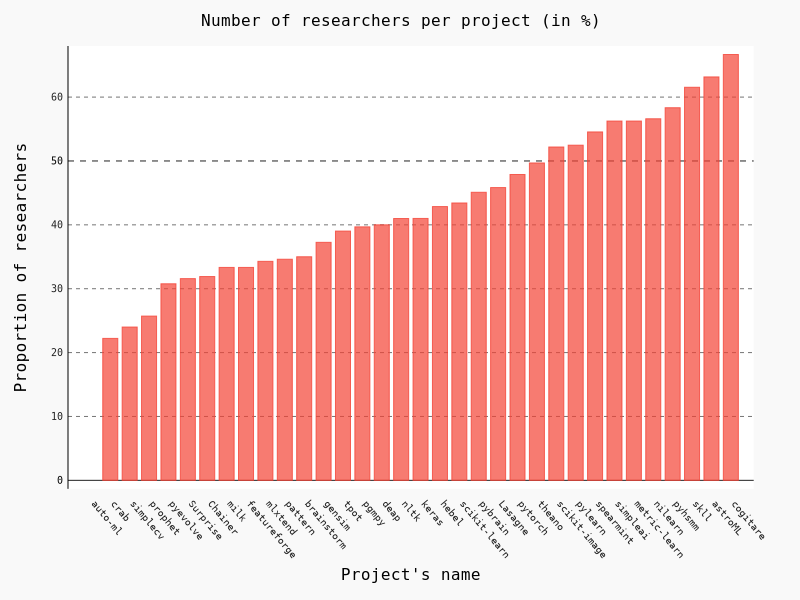

In [8]:
def compute_researchers(project_name):
    global projects_commits
    
    project_commits = projects_commits[project_name].drop_duplicates(['PROJECT', 'AUTHOR_NAME'])
    
    return len(project_commits[project_commits['IS_RESEARCHER'] == True]) / len(project_commits)

projects_to_researchers = []
for name in projects_commits.keys():
    researchers_count = compute_researchers(name)
    projects_to_researchers.append([name, compute_researchers(name)])
    
projects_to_researchers = np.array(sorted(projects_to_researchers, key = itemgetter(1)))
projects_names = projects_to_researchers[:, 0]

bar = pygal.Bar(x_label_rotation = 50, show_legend = False)
bar.title = 'Number of researchers per project (in %)'
bar.x_title = 'Project\'s name'
bar.y_title = 'Proportion of researchers'
bar.x_labels = projects_names
bar.add('Researchers', np.array(list(map(float, list(projects_to_researchers[:, 1])))) * 100)

##### Observations

Sur les quatorze projets étudiés, nous avons :
* Un projet qui ne compte aucun chercheur (*auto-ml*).
* Deux projets dont les contributeurs sont majoritairement des chercheurs (*scikit-image*, *cogitare*).
* Onze projets dont les contributeurs ne sont pas majoritairement des chercheurs.


Nous pouvons conclure, pour cet échantillon de projet, que les chercheurs ne sont pas en majorité dans les projets open source de Machine Learning.

##### Ouverture

Nous observons que dans la plupart des projets, un quart des contributeurs au moins est composé de chercheurs (vrai pour douze projets, sur quatorze). Nous nous posons la question : cette observation pourrait-elle être faite pour n'importe quel type de projet open source ?

### Les contributions sont-elles majoritairement produites par des chercheurs ?

#### En nombre de *commits*

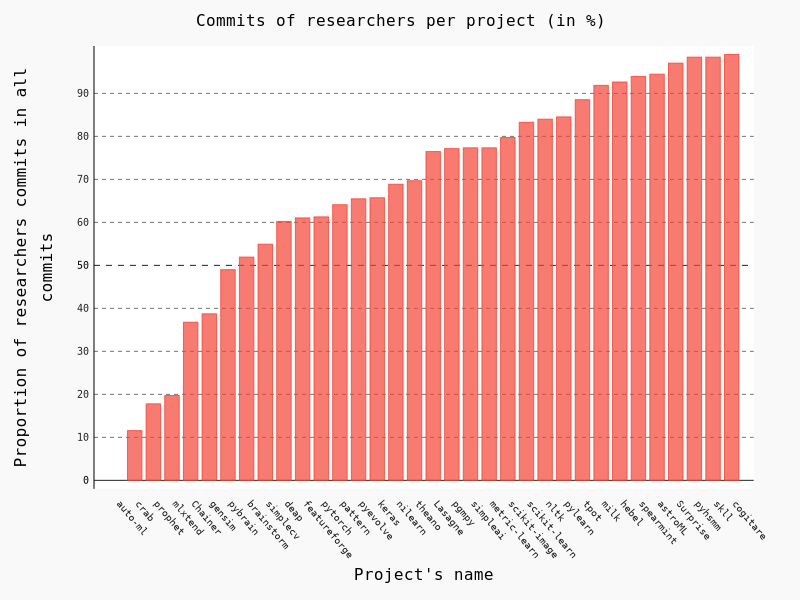

In [9]:
def compute_researchers(project_name):
    global projects_commits
    
    project_commits = projects_commits[project_name]
    
    return len(project_commits[project_commits['IS_RESEARCHER'] == True]) / len(project_commits)

projects_to_researchers = []
for name in projects_commits.keys():
    projects_to_researchers.append([name, compute_researchers(name)])
    
projects_to_researchers = np.array(sorted(projects_to_researchers, key = itemgetter(1)))
projects_names = projects_to_researchers[:, 0]

bar = pygal.Bar(x_label_rotation = 50, show_legend = False)
bar.title = 'Commits of researchers per project (in %)'
bar.x_title = 'Project\'s name'
bar.y_title = 'Proportion of researchers commits in all commits'
bar.x_labels = projects_names
bar.add('Researchers', np.array(list(map(float, list(projects_to_researchers[:, 1])))) * 100)

#### En nombre de lignes ajoutées/retirées

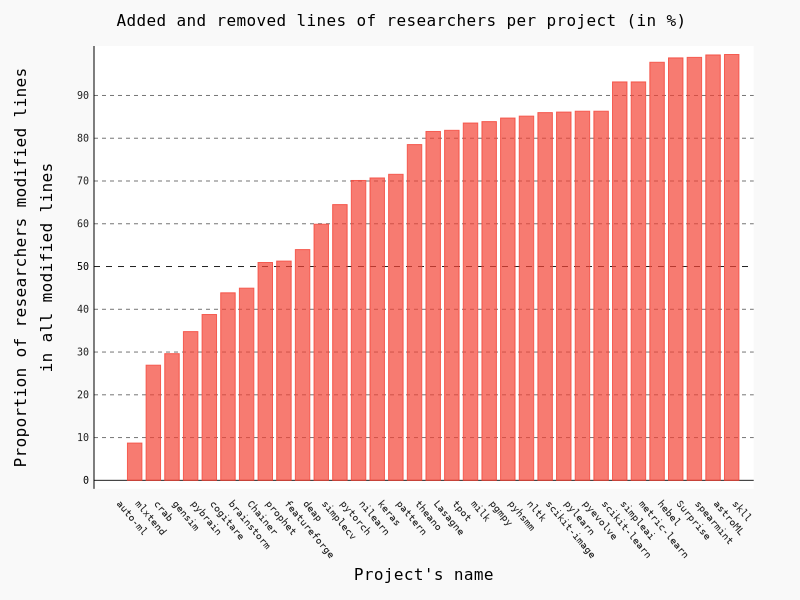

In [10]:
def compute_researchers(project_name):
    global projects_commits
    
    project_commits = projects_commits[project_name]
    
    return (project_commits['ADDED_LINES'][project_commits['IS_RESEARCHER'] == True].sum() + project_commits['DELETED_LINES'][project_commits['IS_RESEARCHER'] == True].sum()) / (project_commits['ADDED_LINES'].sum() + project_commits['DELETED_LINES'].sum())

projects_to_researchers = []
for name in projects_commits.keys():
    projects_to_researchers.append([name, compute_researchers(name)])
    
projects_to_researchers = np.array(sorted(projects_to_researchers, key = itemgetter(1)))
projects_names = projects_to_researchers[:, 0]

bar = pygal.Bar(x_label_rotation = 50, show_legend = False)
bar.title = 'Added and removed lines of researchers per project (in %)'
bar.x_title = 'Project\'s name'
bar.y_title = 'Proportion of researchers modified lines in all modified lines'
bar.x_labels = projects_names
bar.add('Researchers', np.array(list(map(float, list(projects_to_researchers[:, 1])))) * 100)

##### Observations

Bien que les observations diffèrent en fonction de la notion de contribution (nombre de *commits* ou nombre de *lignes ajoutées/retirées*), nous observons que la tendance est à une grande participation des chercheurs à la progression des projets :
* Les *commits* sont majoritairement faits par des chercheurs dans douze projets sur quatorze.
* Les lignes sont majoritairement écrites par des chercheurs dans dix projets sur quatorze.
* Les lignes sont majoritairement supprimées par des chercheurs dans onze projets sur quatorze.

Nous observons également des *anomalies* :
* Dans *cogitare*, toutes les contributions sauf une proviennent de chercheurs, mais moins de la moitié des lignes de code a été écrit par eux. Ce *commit* a été produit par "Travis CI User" (outil d'intégration continue), c'est donc une erreur de l'avoir conservé.
* Le projet *auto-ml* parasite les résultats car nous avons déterminé au point précédent qu'aucun chercheur n'a contribué à ce projet.

### Les chercheurs sont-ils les contributeurs qui contribuent le plus individuellement ?

In [11]:
def decide_if_commit_made_by_researcher(row):
    global contributors_status
    
    row['IS_RESEARCHER'] = contributors_status['IS_RESEARCHER'][row['NAME']]
    
    return row

def compute_contributors_statistics(commits):
    statistics = pd.DataFrame(index = commits['AUTHOR_NAME'].unique())
    
    statistics['NUMBER_OF_COMMITS'] = 0
    statistics['ADDED_LINES'] = 0
    statistics['DELETED_LINES'] = 0
    statistics['MODIFIED_LINES'] = 0
    
    for index, row in commits.iterrows():
        name = row['AUTHOR_NAME']
        
        statistics['NUMBER_OF_COMMITS'][name] += 1
        statistics['ADDED_LINES'][name] += row['ADDED_LINES']
        statistics['DELETED_LINES'][name] += row['DELETED_LINES']
        statistics['MODIFIED_LINES'][name] += row['ADDED_LINES'] + row['DELETED_LINES']
        
    statistics['NAME'] = statistics.index
    
    statistics = statistics.apply(decide_if_commit_made_by_researcher, axis = 1)
    
    statistics.reset_index(drop = True, inplace = True)
        
    return statistics

projects_contributors = {}

for project_name in projects_commits.keys():
    contributors = compute_contributors_statistics(projects_commits[project_name])
    contributors['PROJECT'] = project_name
    
    projects_contributors[project_name] = contributors
    
contributors = pd.concat(projects_contributors.values())
contributors.reset_index(drop = True, inplace = True)

contributors.sample(3)

,NUMBER_OF_COMMITS,ADDED_LINES,DELETED_LINES,MODIFIED_LINES,NAME,IS_RESEARCHER,PROJECT
3038,2,262,250,512,Piotr Kasprzyk,False,nltk
4176,1,1,1,2,Manuel,False,scikit-learn
1949,37,1095,338,1433,Michael Oliver,True,keras


#### En nombre de *commits*

In [12]:
r = pd.DataFrame()

r = r.append(contributors[contributors['PROJECT'] == 'scikit-learn']['NUMBER_OF_COMMITS'].describe(), ignore_index = True)
r = r.append(contributors[contributors['PROJECT'] == 'theano']['NUMBER_OF_COMMITS'].describe(), ignore_index = True)

r

,25%,50%,75%,count,max,mean,min,std
0,1.0,2.0,4.0,1239.0,2287.0,19.454399,1.0,128.001947
1,1.0,3.0,13.0,479.0,3736.0,58.519833,1.0,299.571373


In [23]:
sum_up_researchers = pd.DataFrame()
sum_up_non_researchers = pd.DataFrame()

for project_name in contributors['PROJECT'].unique():
    project_contributors = contributors[contributors['PROJECT'] == project_name]
    
    project_commits = project_contributors['NUMBER_OF_COMMITS'].sum()
    
    sum_up_researchers = sum_up_researchers.append(project_contributors[project_contributors['IS_RESEARCHER'] == True]['NUMBER_OF_COMMITS'].describe() / project_commits, ignore_index = True)
    sum_up_non_researchers = sum_up_non_researchers.append(project_contributors[project_contributors['IS_RESEARCHER'] == False]['NUMBER_OF_COMMITS'].describe() / project_commits, ignore_index = True)

In [24]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of commits per contributor (mean)'
plot.x_title = 'Contributor type'
plot.y_title = 'Mean of normalized number of commits'
plot.add('Researchers', sum_up_researchers['mean'])
plot.add('Non researchers', sum_up_non_researchers['mean'])

plot.render_to_png('/home/antoine/commits_mean.png')

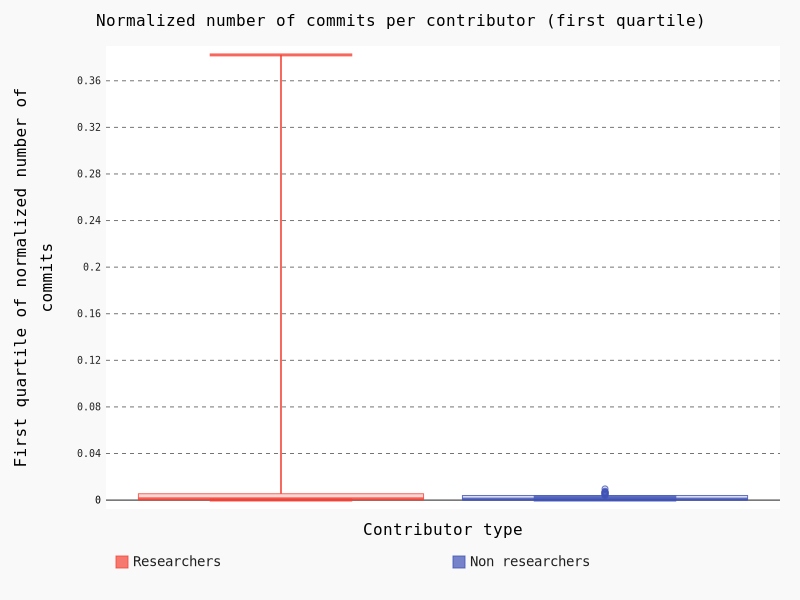

In [25]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of commits per contributor (first quartile)'
plot.x_title = 'Contributor type'
plot.y_title = 'First quartile of normalized number of commits'
plot.add('Researchers', sum_up_researchers['25%'])
plot.add('Non researchers', sum_up_non_researchers['25%'])

In [26]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of commits per contributor (median)'
plot.x_title = 'Contributor type'
plot.y_title = 'Median of normalized number of commits'
plot.add('Researchers', sum_up_researchers['50%'])
plot.add('Non researchers', sum_up_non_researchers['50%'])

plot.render_to_png('/home/antoine/commits_median.png')

In [27]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of commits per contributor (third quartile)'
plot.x_title = 'Contributor type'
plot.y_title = 'Third quartile of normalized number of commits'
plot.add('Researchers', sum_up_researchers['75%'])
plot.add('Non researchers', sum_up_non_researchers['75%'])

plot.render_to_png('/home/antoine/commits_third_quartile.png')

#### En nombre de lignes ajoutées/retirées

In [28]:
sum_up_researchers = pd.DataFrame()
sum_up_non_researchers = pd.DataFrame()

for project_name in contributors['PROJECT'].unique():
    project_contributors = contributors[contributors['PROJECT'] == project_name]
    
    project_contributors['MODIFIED_LINES'] = project_contributors['ADDED_LINES'] + project_contributors['DELETED_LINES']
    project_modified_lines = project_contributors['MODIFIED_LINES'].sum()
    
    sum_up_researchers = sum_up_researchers.append(project_contributors[project_contributors['IS_RESEARCHER'] == True]['MODIFIED_LINES'].describe() / project_modified_lines, ignore_index = True)
    sum_up_non_researchers = sum_up_non_researchers.append(project_contributors[project_contributors['IS_RESEARCHER'] == False]['MODIFIED_LINES'].describe() / project_modified_lines, ignore_index = True)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [29]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of modified lines per contributor (mean)'
plot.x_title = 'Contributor type'
plot.y_title = 'Mean of normalized number of modified lines'
plot.add('Researchers', sum_up_researchers['mean'])
plot.add('Non researchers', sum_up_non_researchers['mean'])

plot.render_to_png('/home/antoine/modified_lines_mean.png')

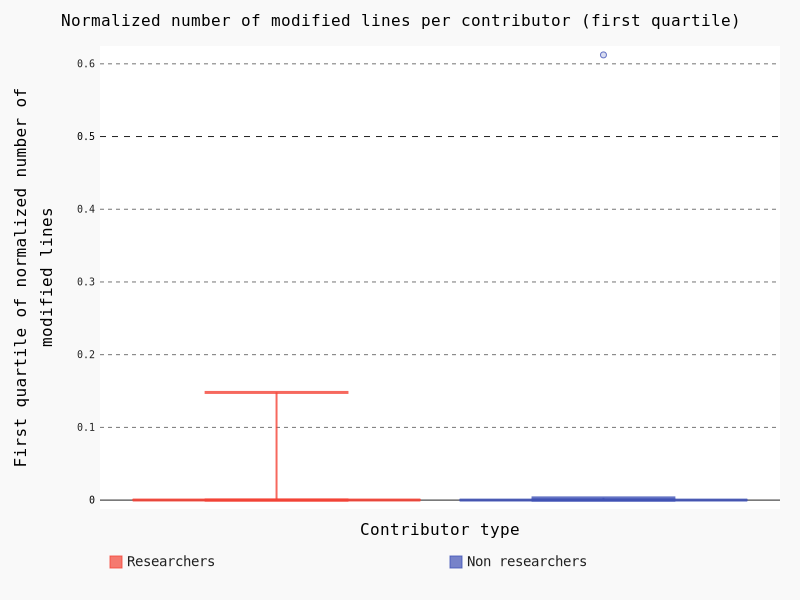

In [30]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of modified lines per contributor (first quartile)'
plot.x_title = 'Contributor type'
plot.y_title = 'First quartile of normalized number of modified lines'
plot.add('Researchers', sum_up_researchers['25%'])
plot.add('Non researchers', sum_up_non_researchers['25%'])

In [31]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of modified lines per contributor (median)'
plot.x_title = 'Contributor type'
plot.y_title = 'Median of normalized number of modified lines'
plot.add('Researchers', sum_up_researchers['50%'])
plot.add('Non researchers', sum_up_non_researchers['50%'])

plot.render_to_png('/home/antoine/modified_lines_median.png')

In [32]:
plot = pygal.Box(box_mode = 'stdev', legend_at_bottom = True)
plot.title = 'Normalized number of modified lines per contributor (third quartile)'
plot.x_title = 'Contributor type'
plot.y_title = 'Third quartile of normalized number of modified lines'
plot.add('Researchers', sum_up_researchers['75%'])
plot.add('Non researchers', sum_up_non_researchers['75%'])

plot.render_to_png('/home/antoine/modified_lines_third_quartile.png')